In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import sys
import random
import functions
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from functions import *
from sklearn.model_selection import train_test_split
from pylab import rcParams
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import r2_score
import tensorflow as tf
import os
import datetime as dt
from tqdm import tnrange, tqdm_notebook, tqdm

In [2]:
df_train,df_test=LoadandCleanData(True,1,0.0,2)

In [3]:
m=df_train['y'].mean()
std=df_train['y'].std()
df_train['y']=df_train['y'].apply(lambda x: (x-m)/std)
#minv=min(df_train['y'].values)
#maxv,minv
N=len(df_train)

In [4]:
tf.reset_default_graph()
sess = tf.Session()

In [5]:
X = tf.placeholder(tf.float32,shape=[N,480], name="X")
Y = tf.placeholder(tf.float32,shape=[N,1] ,name="Y")

w1 = tf.Variable(tf.truncated_normal([480,140], stddev=0.00001), name="weights1")
b1=tf.Variable(tf.constant(0.0,shape=[140]), name="bias1")

w2 = tf.Variable(tf.truncated_normal([140,40], stddev=0.00001), name="weights2")
b2=tf.Variable(tf.constant(0.0,shape=[40]), name="bias2")

w3 = tf.Variable(tf.truncated_normal([40,1], stddev=0.00001), name="weights3")
b3=tf.Variable(tf.constant(0.0,shape=[1]), name="bias3")


Y1= tf.nn.relu(tf.matmul(X,w1)+b1)
Y2= tf.nn.relu(tf.matmul(Y1,w2)+b2)
Y_predicted = tf.matmul(Y2,w3)+b3

step=tf.square(Y - Y_predicted,name="step")
chi2= tf.reduce_sum(step, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(chi2)
tf.summary.histogram("weights1", w1)
tf.summary.histogram("biases1", b1)
tf.summary.histogram("weights2", w2)
tf.summary.histogram("biases2", b2)
tf.summary.histogram("weights3", w3)
tf.summary.histogram("biases3", b3)

tf.summary.histogram("Y", Y_predicted)
tf.summary.scalar("chi2", chi2)
summ = tf.summary.merge_all()

In [6]:
inputdata=df_train.drop("y",axis=1).as_matrix()

In [7]:
type(inputdata),inputdata.shape

(numpy.ndarray, (4209, 480))

In [8]:
inputy=df_train['y'].as_matrix()

In [9]:
inputy

array([ 2.37714138, -0.95740619, -1.92511902, ...,  0.6743769 ,
       -1.0402178 ,  0.80293207])

In [10]:
LOGDIR="./tf/{}/".format(dt.datetime.now().strftime('%Y%m%d_%H_%M_%S'))
saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

In [11]:
#with tf.Session() as sess:
# Step 7: initialize the necessary variables, in this case, w and b
sess.run(tf.global_variables_initializer())
# Step 8: train the model
for j in tqdm(range(1000)): # run 100 epochs
    sess.run(optimizer,feed_dict={X:inputdata, Y:inputy.reshape(N,1)})  
    if j%5==0:
        s = sess.run(summ, feed_dict={X:inputdata, Y:inputy.reshape(N,1)})
        writer.add_summary(s, j)  
        saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), j)


100%|██████████| 1000/1000 [01:47<00:00,  7.31it/s]


In [12]:
testdata=df_test.as_matrix()
#testdata[0].reshape(1,480)

In [13]:
Ytest=sess.run([Y_predicted],feed_dict={X: testdata})
Ytrain=sess.run([Y_predicted],feed_dict={X: inputdata})

In [14]:
#[loss1,step1,b1]=sess.run([loss,step,b], feed_dict={X:inputdata, Y:inputy.reshape(N,1)})
sess.close()

In [15]:
Ytrainv=[i[0] for i in Ytrain[0][0:]]
Ytrestv=[i[0] for i in Ytest[0][0:]]

In [16]:
type(Ytrainv)

list

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00237812,  0.05707491,
         0.078478  ,  0.03567182,  0.01783591,  0.04280618,  0.24256837,
         0.68727705,  0.56718193,  0.34601665,  0.28656361,  0.35077289,
         0.24613555,  0.24851367,  0.38049941,  0.43876338,  0.30083234,
         0.21403092,  0.13079667,  0.08680143,  0.06420927,  0.03091558,
         0.03091558,  0.02497027,  0.01902497,  0.01426873,  0.01189061,
         0.01307967,  0.0059453 ,  0.00356718,  0.00356718,  0.0059453 ,
         0.00237812,  0.00475624,  0.00237812,  0.00118906]),
 array([ -5.00000000e+00,  -4.80000000e+00,  -4.60000000e+00,
         -4.40000000e+00,  -4.20000000e+00,  -4.00000000e+00,
         -3.80000000e+00,  -3.60000000e+00,  -3.40000000e+00,
         -3.20000000e+00,  -3.00000000e+00,  -2.80000000e+00,
         -2.60000000e+00,  -2.400

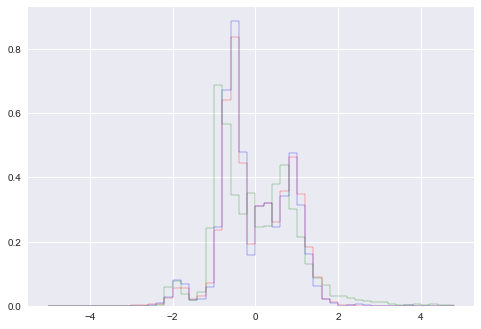

In [17]:
plt.hist(Ytrestv,bins=np.mgrid[-5:5:0.2],color="red",histtype="step",normed=True)
plt.hist(Ytrainv,bins=np.mgrid[-5:5:0.2],color='blue',histtype="step",normed=True)
plt.hist(df_train["y"].values,bins=np.mgrid[-5:5:0.2],color='green',histtype="step",normed=True)

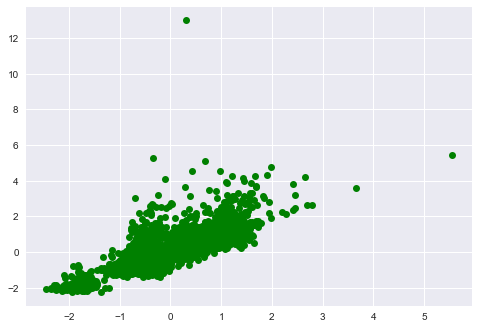

In [18]:
plt.plot(Ytrainv,df_train["y"].values,"go")